In [1]:
import glob
import venn
from scipy.cluster.hierarchy import dendrogram, linkage
from neupy import algorithms
from scipy.stats.stats import pearsonr   
from scipy.interpolate import interp1d
import itertools as it
import statsmodels.stats.multitest as multi
import Colors
from matplotlib.patches import Rectangle, Circle
from colour import Color

In [2]:
np.random.seed(174632)

In [3]:
def zscore(df):
    df = df.loc[df.index[df.sum(axis=1)>0]]
    zdf = df.T
    zdf = (zdf-zdf.mean())/zdf.std()
    zdf = zdf.T
    return zdf

def scalezscore(zdf):
    df  = ((zdf.T>=0)*zdf.T/zdf.max(axis=1) + (zdf.T<0)*zdf.T/abs(zdf.min(axis=1))).T
    return df

In [4]:
g_annotate=['Cdx2','Rspo3','Sox1','Sox2','Wnt3a','Fgf8','Uncx','Aldh1a2','Nkx1-2','Cyp26a1', 'Foxb1', 'Ets2',
            'Hes3','Pax6','Irx3','Irx5','Sox21','Dbx1','Dll1','Meox1','Tcf15','Pax3','Ptn','Klf3','Spon1', 'Rab3il1',
          'Mesp2','Ripply2','Dppa5a','Meox1','Tbx6','T', 'Hand1', 'Hand2', 'Gata6', 'Mef2c']

# read Lfng tomo data

In [6]:
zdf_L = read_csv('../mGav_Lfng_zscores.tsv.gz', sep = '\t', index_col=0)

In [7]:
zdf_L.columns = [c + '_Lfng' for c in zdf_L.columns]

In [8]:
zdf_L.index = ['_'.join(idx.rsplit('_')[:2]) for idx in zdf_L.index]

In [9]:
zdf_L.head()

,0_Lfng,1_Lfng,2_Lfng,3_Lfng,4_Lfng,5_Lfng,6_Lfng,7_Lfng,8_Lfng,9_Lfng,...,34_Lfng,35_Lfng,36_Lfng,37_Lfng,38_Lfng,39_Lfng,40_Lfng,41_Lfng,42_Lfng,43_Lfng
ENSMUSG00000026434_Nucks1,-0.449391,0.195955,-0.501097,0.938777,-0.264203,0.822116,-0.251743,0.923764,-0.625716,0.320964,...,-0.036993,0.072502,-0.055321,-0.025353,0.069885,-0.827685,0.009932,0.561467,0.164336,0.171120
ENSMUSG00000006304_Arpc2,-0.855291,0.306949,0.294913,-0.144060,-0.602914,0.558077,-0.286693,0.558643,-0.280558,-0.029433,...,-0.245501,-0.245593,0.463782,-0.464974,0.516456,-0.098695,1.962686,-0.072440,0.655563,-0.401975
ENSMUSG00000076432_Ywhaq,-2.057338,0.728396,0.870007,-0.203909,0.605929,0.544945,0.783336,-0.210597,0.441872,-0.596599,...,-0.255940,0.010108,-0.430118,0.809210,0.248145,-0.220032,0.314043,0.054481,-0.207551,-0.606773
ENSMUSG00000020349_Ppp2ca,-0.656009,0.015812,0.448384,-1.312120,-0.300592,-0.383851,-0.114543,-0.263290,-0.366393,0.004947,...,-0.313838,0.777509,0.140493,0.927088,0.474586,0.415582,1.452005,0.615186,-0.592499,-0.405854
ENSMUSG00000044285_Gm1821,-0.343481,0.166676,0.626895,-0.050701,0.942606,0.099392,1.596538,0.943766,0.696571,-0.035144,...,-0.364478,0.009755,0.395555,0.203245,0.029799,-0.662316,-0.534567,-0.736883,-1.036519,-0.460247


In [10]:
gene_corr_L = read_csv('../results/lfngMouseGastruloids/geneCorrelations_5dAA.tsv', sep = '\t', index_col=0)

In [11]:
gene_corr_L.index = ['_'.join(idx.rsplit('_')[:2]) for idx in gene_corr_L.index]

In [12]:
gene_corr_L.head()

,"corr_(0, 1)","pv_(0, 1)","adj-pv_(0, 1)","corr_(0, 2)","pv_(0, 2)","adj-pv_(0, 2)","corr_(1, 2)","pv_(1, 2)","adj-pv_(1, 2)"
ENSMUSG00000000001_Gnai3,-0.052702,0.648430,0.849729,-0.026991,0.582617,0.878416,-0.065006,0.671834,0.885385
ENSMUSG00000000028_Cdc45,-0.149606,0.857471,0.900678,0.233418,0.042509,0.309357,-0.092482,0.739648,0.885385
ENSMUSG00000000031_H19,0.563323,0.000000,0.000000,0.528238,0.000000,0.000000,0.553930,0.000000,0.000000
ENSMUSG00000000037_Scml2,-0.174997,0.892879,0.922340,0.080947,0.279956,0.878416,0.133182,0.181936,0.692565
ENSMUSG00000000056_Narf,-0.196799,0.918484,0.939695,0.150490,0.131726,0.599934,0.124855,0.197139,0.721206


In [13]:
pvcols = [c for c in gene_corr_L.columns if 'pv_('==c[:4]]
pvth = 0.1; nth = 3
genelist_L = gene_corr_L.index[gene_corr_L.apply(lambda x: sum(x[pvcols]<pvth), axis = 1) >= nth]

In [14]:
gcL = gene_corr_L[pvcols].mean(axis=1)

# read E14 gastruloid data

In [15]:
zdf_E = read_csv('../../E14-mGstl-tomo/mGav_E14_zscores.tsv.gz', sep = '\t', index_col=0)

In [16]:
zdf_E.columns = [c + '_E14' for c in zdf_E.columns]

In [17]:
zdf_E.index = ['_'.join(idx.rsplit('_')[:2]) for idx in zdf_E.index]

In [18]:
zdf_E.head()

,0_E14,1_E14,2_E14,3_E14,4_E14,5_E14,6_E14,7_E14,8_E14,9_E14,10_E14,11_E14,12_E14,13_E14
ENSMUSG00000019923_Zwint,0.498391,-0.074597,0.016306,-0.156802,0.385915,0.288776,-0.247923,-0.396988,-0.029880,-0.395479,-0.198332,-0.095654,0.651648,0.027561
ENSMUSG00000022337_Emc2,0.515047,0.027935,0.145076,-0.009946,-0.554797,-0.057087,-0.187095,-0.127993,0.426656,0.020248,-0.078655,-0.160912,0.106611,0.111534
ENSMUSG00000020850_Prpf8,0.172339,-0.104309,-0.131889,0.091707,-0.608869,-0.531869,0.098276,-0.057002,0.164178,0.355825,-0.148202,-0.234685,0.268221,0.784613
ENSMUSG00000021555_Naa35,-0.036170,0.496449,0.259666,-0.146526,0.740443,-0.479922,0.377205,0.237120,0.120180,-0.143646,-0.236636,-0.167154,-0.475774,-0.197116
ENSMUSG00000038429_Usp5,-0.598733,-0.396259,0.011927,0.324319,-0.430119,-0.357687,0.134483,0.288219,0.131091,0.221346,0.292730,-0.078545,0.073618,0.300952


In [19]:
gene_corr_E = read_csv('../../E14-mGstl-tomo/results_postRevJan19/geneCorrelations_5dAA.tsv', sep = '\t', index_col=0)

In [20]:
gene_corr_E.index = ['_'.join(idx.rsplit('_')[:2]) for idx in gene_corr_E.index]

In [21]:
gene_corr_E.head()

,"corr_(0, 1)","pv_(0, 1)","adj-pv_(0, 1)","corr_(0, 2)","pv_(0, 2)","adj-pv_(0, 2)","corr_(0, 3)","pv_(0, 3)","adj-pv_(0, 3)","corr_(0, 4)",...,"adj-pv_(1, 4)","corr_(2, 3)","pv_(2, 3)","adj-pv_(2, 3)","corr_(2, 4)","pv_(2, 4)","adj-pv_(2, 4)","corr_(3, 4)","pv_(3, 4)","adj-pv_(3, 4)"
ENSMUSG00000000001_Gnai3,0.108611,0.359972,0.799886,-0.409809,0.936687,0.986075,-0.362883,0.909882,0.987603,-0.247878,...,0.956262,0.010513,0.487998,0.976052,0.516916,0.031506,0.322633,0.001357,0.501400,0.983297
ENSMUSG00000000028_Cdc45,-0.310235,0.875075,0.960766,0.156454,0.284957,0.798598,-0.447652,0.952290,0.997602,-0.215572,...,0.829490,-0.224320,0.784857,0.979266,-0.545152,0.976695,0.996928,0.009575,0.475995,0.974456
ENSMUSG00000000031_H19,0.168878,0.280756,0.721239,-0.172194,0.725245,0.945054,-0.033785,0.554411,0.955349,0.550434,...,0.829490,0.960320,0.000000,0.000000,0.305910,0.144729,0.637516,0.515512,0.000000,0.000000
ENSMUSG00000000037_Scml2,0.513864,0.027305,0.250767,0.336358,0.112523,0.531690,-0.190042,0.753051,0.955630,-0.406896,...,0.950081,-0.089681,0.626625,0.978737,-0.103671,0.633827,0.940262,0.045418,0.361372,0.888408
ENSMUSG00000000056_Narf,0.587155,0.012302,0.164138,0.562611,0.015303,0.179756,-0.545720,0.981496,1.000000,0.490935,...,0.956262,-0.652931,0.994899,1.000000,0.075714,0.390778,0.921212,-0.029765,0.597019,1.000000


In [22]:
pvcols = [c for c in gene_corr_E.columns if 'pv_('==c[:4]]
pvth = 0.1; nth = 5
genelist_E = gene_corr_E.index[gene_corr_E.apply(lambda x: sum(x[pvcols]<pvth), axis = 1) >= nth]

In [23]:
gcE = gene_corr_E[pvcols].mean(axis=1)

# read mouse embryo data

In [25]:
zdf_embryo = read_csv('../../mEmbryo-tomo/mEav_embryo_zscores.tsv.gz', sep= '\t', index_col=0)

In [26]:
zdf_embryo.columns = [c + '_embryo' for c in zdf_embryo.columns]

In [27]:
zdf_embryo.index = ['_'.join(idx.rsplit('_')[:2]) for idx in zdf_embryo.index]

In [28]:
zdf_embryo.head()

,0_embryo,1_embryo,2_embryo,3_embryo,4_embryo,5_embryo,6_embryo,7_embryo,8_embryo,9_embryo,...,106_embryo,107_embryo,108_embryo,109_embryo,110_embryo,111_embryo,112_embryo,113_embryo,114_embryo,115_embryo
ENSMUSG00000000001_Gnai3,0.640696,-0.764201,0.232510,0.108225,1.498396,0.442224,0.661784,0.146637,0.858475,0.726631,...,-0.377473,0.009438,-0.376801,-0.305406,-0.383478,0.216373,-0.509122,0.261806,-0.131821,0.582506
ENSMUSG00000000028_Cdc45,1.070640,-0.724828,-0.215750,0.379887,1.367949,0.989976,0.130553,-0.659542,0.430818,0.596404,...,-0.143042,-0.237933,0.739713,0.072932,-0.649806,0.375346,-0.550609,-0.343071,-0.842518,-0.613720
ENSMUSG00000000031_H19,-1.247631,-1.269960,-1.242558,-1.218631,-1.155355,-1.106325,-1.155643,-1.034096,-0.847465,-0.948919,...,1.328089,1.155069,1.314232,0.112262,0.363764,0.700086,0.281127,0.352786,0.564183,1.140711
ENSMUSG00000000037_Scml2,-0.556929,0.540387,0.758529,-0.625890,1.385358,0.499649,2.048389,-0.625890,-0.625890,-0.056819,...,-0.625890,0.101281,0.188178,0.020617,-0.567854,-0.442354,0.589701,-0.625890,-0.625890,-0.047661
ENSMUSG00000000049_Apoh,-0.120308,-0.111155,-0.111155,-0.111155,-0.111155,-0.104725,-0.111155,-0.111155,-0.111155,2.189018,...,-0.111155,-0.111155,-0.111155,-0.111155,-0.104725,-0.111155,-0.111155,-0.111155,-0.111155,-0.114816


In [29]:
file = '/Users/anna/Dropbox/gastruloids/data/mEmbryo-tomo/results/batchCorrection/gene_correlations.tsv'
gene_corr_embryo = read_csv(file, sep = '\t', index_col=0)

In [30]:
gene_corr_embryo.index = ['_'.join(idx.rsplit('_')[:2]) for idx in gene_corr_embryo.index]

In [31]:
gene_corr_embryo.head()

,"corr_(0, 1)","pv_(0, 1)","adj-pv_(0, 1)","corr_(0, 2)","pv_(0, 2)","adj-pv_(0, 2)","corr_(1, 2)","pv_(1, 2)","adj-pv_(1, 2)"
ENSMUSG00000000001_Gnai3,-0.050721,0.706041,0.865949,-0.028415,0.638028,0.892001,0.013253,0.442188,0.880900
ENSMUSG00000000028_Cdc45,0.097165,0.137528,0.530108,-0.026508,0.628826,0.892001,0.062677,0.240948,0.834113
ENSMUSG00000000031_H19,0.645632,0.000000,0.000000,0.551900,0.000000,0.000000,0.585035,0.000000,0.000000
ENSMUSG00000000037_Scml2,-0.001240,0.495799,0.850572,0.093135,0.151530,0.647430,0.274814,0.002300,0.035643
ENSMUSG00000000049_Apoh,-0.015966,0.560812,0.850572,-0.014435,0.578616,0.892001,-0.007508,0.529606,0.880900


In [32]:
pvcols = [c for c in gene_corr_embryo.columns if 'pv_('==c[:4]]
pvth = 0.1; nth = 3
genelist_embryo = gene_corr_embryo.index[gene_corr_embryo.apply(lambda x: sum(x[pvcols] < pvth), axis = 1) >= nth]

In [33]:
gcEmbryo = gene_corr_embryo[pvcols].mean(axis=1)

# clustering

In [32]:
def SOMclustering(df, gridheight = 10, gridwidth = 10, seed = 54321):
    np.random.seed = seed
    GRID_HEIGHT = gridheight
    GRID_WIDTH = gridwidth
    somfun = algorithms.SOFM(
            n_inputs=len(df.columns),
            features_grid=(GRID_HEIGHT, GRID_WIDTH),
            learning_radius=4,
            reduce_radius_after=50,
            step=0.5,
            std=1,
            shuffle_data=True,
            verbose=False)
    somfun.train(np.array(df), epochs = 300)
    clustersr = somfun.predict(np.array(df)).argmax(axis=1)
    cl_genelist_df = pd.Series(clustersr, index = df.index)
    return cl_genelist_df

def hierarchicalClustering(df, cth = 100, plot = False, method = 'ward', metric = 'euclidean', nolabels = 'True'):
    Z = linkage(df, method=method, metric = metric)
    dg = dendrogram(Z, no_labels=nolabels, color_threshold=cth, no_plot = np.invert(plot))
    plt.show()
    return Z, dg

def getClusterByColor(dg, labels):
    kk = []
    ii = 0
    cluster = 0
    color = dg['color_list'][0]
    clusters = {cluster: []}
    for i in range(len(dg['icoord'])):
        v = dg['icoord'][i]
        for j in [0,2]:
            vj = int(round((v[j]-5.)/10))
            if (v[j]-5.)/10 == vj and vj not in kk:
                kk.append(vj)
                if dg['color_list'][i] == color:
                    clusters[cluster].append(labels[dg['leaves'][vj]])
                else:
                    color = dg['color_list'][i]
                    cluster += 1
                    clusters[cluster] = [labels[dg['leaves'][vj]]]
    return clusters

def comboCluster(df, genes, gridheight = 10, gridwidth = 10, cth = 100, plot = True, method = 'ward', metric = 'euclidean', seed = 12345, nolabels = 'True'):
    somcl = SOMclustering(df.loc[genes], gridheight = gridheight, gridwidth = gridwidth, seed = seed)
    mdf_som = pd.DataFrame({i: df.loc[somcl[somcl==i].index].mean() for i in set(somcl) })
    Z, dg = hierarchicalClustering(mdf_som.T, cth = cth, plot = plot, method = method, metric = metric, nolabels = nolabels)
    if plot:
        plt.show()
    ghcl = getClusterByColor(dg, list(mdf_som.columns))
    cl_df = pd.DataFrame(somcl, columns = ['som'])
    cl_df['hcl'] = [k for s in cl_df['som'] for k in ghcl.keys() if s in ghcl[k]]
    return cl_df

In [33]:
def mergeDfs(dfs):
    mdf = dfs[0]
    for i in range(1, len(dfs)):
        mdf = mdf.merge(dfs[i], how = 'outer', left_index = True, right_index = True)
    mdf = mdf.fillna(0)
    mdf = mdf.loc[mdf.sum(axis=1).sort_values(ascending=False).index]
    return mdf

# Lnfg compared to Embryo
Let's take all genes, expressed in both systems

In [34]:
gene_EmbryoLfng = list(set(list(genelist_L)+list(genelist_embryo)))
gene_EmbryoLfng = [g for g in gene_EmbryoLfng if g in zdf_L.index and g in zdf_embryo.index 
                  and g in gcL.index and g in gcEmbryo.index]
len(gene_EmbryoLfng), 5*np.sqrt(len(gene_EmbryoLfng))

(2488, 249.39927826679852)

In [35]:
zdf_L.shape, gcL.shape, zdf_E.shape, gcE.shape, zdf_embryo.shape, gcEmbryo.shape

((25828, 44), (25828,), (17091, 14), (17091,), (32789, 116), (22669,))

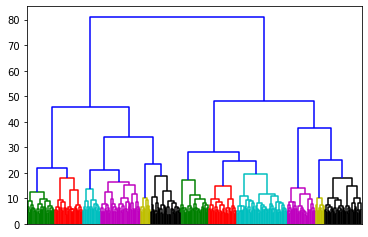

In [36]:
somhcl_LfngEmbryo_df = comboCluster(mergeDfs([zdf_L, zdf_embryo]), gene_EmbryoLfng, cth=20, gridheight=20, gridwidth=20)
                                    

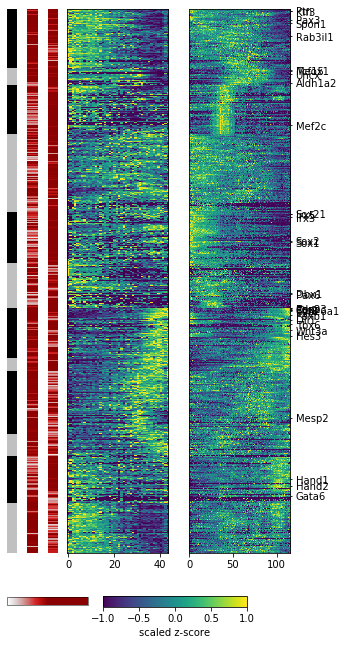

In [37]:
fig, ax = plt.subplots(ncols=2, nrows=1, figsize = (4,10))

hcl = somhcl_LfngEmbryo_df
dfs = [zdf_L, zdf_embryo]
gcs = [gcL, gcEmbryo]
gene_order = hcl.sort_values(by=['hcl','som']).index

im = ['' for i in range(len(ax))]
for i, df in enumerate(dfs):
    im[i] = ax[i].imshow(scalezscore(df.loc[gene_order][::-1]), aspect = 'auto')
    ax[i].set_yticks([])
ax[-1].tick_params('y', length = 2, labelleft=False, labelright=True, left = False, right=True)
ax[-1].set_yticks([i for i, g in enumerate(gene_order[::-1]) if g.rsplit('_')[1] in g_annotate])
ax[-1].set_yticklabels([g.rsplit('_')[1] for g in gene_order[::-1] if g.rsplit('_')[1] in g_annotate])

cbaxes = fig.add_axes([0.25, 0.05,0.5, 0.015])
fig.colorbar(im[-1], label = 'scaled z-score', orientation = 'horizontal', cax = cbaxes)

dx = 0.1*len(dfs[0].columns)
x0 = -6*dx
y0 = len(hcl)-0.5
for cl in set(hcl['hcl']):
    c = 'silver' if np.mod(cl,2)==0 else 'k'
    n = (hcl['hcl']==cl).sum()
    rect = Rectangle((x0,y0-n), dx, n, lw = 2, edgecolor = None, facecolor = c, clip_on=False)
    ax[0].add_patch(rect)
    y0 -= n
    
npoints = 100
xra = np.linspace(0,1,npoints)
gcolors = list(Color('darkred').range_to(Color('white'),npoints-1))
colors = {(xra[i],xra[i+1]): gcolors[i].hex_l for i in range(npoints-1)}
for i, gc in enumerate(gcs):
    x0 = (-4+2*i)*dx
    y0 = len(hcl)-0.5
    n = 0
    for i, g in enumerate(gene_order):
        c = colors[[i for i in colors if i[0]<=gc.loc[g]<i[1]][0]]
        rect = Rectangle((x0,y0-n), dx, 1, lw = 2, edgecolor = None, facecolor = c, clip_on=False)
        ax[0].add_patch(rect)
        y0 -= 1
            
dxx = 0
x0 = -6*dx
x1 = -2*dx
dL = 1.0*(x1-x0)/len(colors)
for i, c in enumerate(list(colors.keys())[::-1]):
    rect = Rectangle((x0+dxx,len(gene_order)+200), dxx+dL, 40, edgecolor = None, facecolor = colors[c], clip_on=False)
    ax[0].add_patch(rect)
    dxx += dL
rect = Rectangle((x0,len(gene_order)+200), 2*dxx-dL, 40, edgecolor = 'k', fill = False, clip_on=False, lw = 0.5)
ax[0].add_patch(rect)
    
plt.savefig('../results/comparison_LfngE14_mouse/heatmap_LfngEmbryo_allgenes.pdf', bbox_inches = 'tight')
hcl.sort_values(by=['hcl','som']).to_csv('../results/comparison_LfngE14_mouse/heatmap_LfngEmbryo_allgenes.tsv', sep = '\t')

plt.show()

# E14 compared to Embryo

In [38]:
gene_EmbryoE14 = list(set(list(genelist_E)+list(genelist_embryo)))
gene_EmbryoE14 = [g for g in gene_EmbryoE14 if g in zdf_E.index and g in zdf_embryo.index 
                  and g in gcE.index and g in gcEmbryo.index]
len(gene_EmbryoE14), 5*np.sqrt(len(gene_EmbryoE14))


(2255, 237.43420141167533)

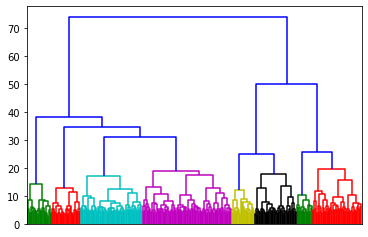

In [40]:
somhcl_E14Embryo_df = comboCluster(mergeDfs([zdf_E, zdf_embryo]), gene_EmbryoE14, cth=20, gridheight=20, gridwidth=20)

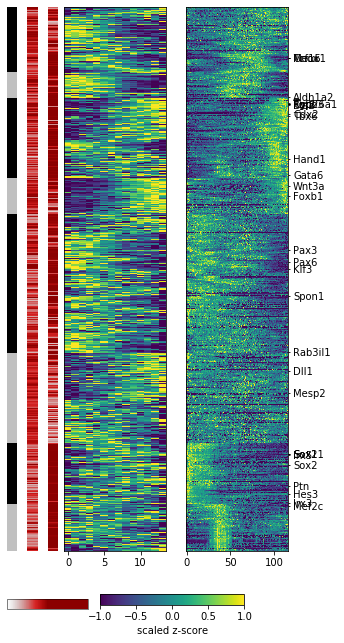

In [41]:
fig, ax = plt.subplots(ncols=2, nrows=1, figsize = (4,10))

hcl = somhcl_E14Embryo_df
dfs = [zdf_E, zdf_embryo]
gcs = [gcE, gcEmbryo]
gene_order = hcl.sort_values(by=['hcl','som']).index

im = ['' for i in range(len(ax))]
for i, df in enumerate(dfs):
    im[i] = ax[i].imshow(scalezscore(df.loc[gene_order][::-1]), aspect = 'auto')
    ax[i].set_yticks([])
ax[-1].tick_params('y', length = 2, labelleft=False, labelright=True, left = False, right=True)
ax[-1].set_yticks([i for i, g in enumerate(gene_order[::-1]) if g.rsplit('_')[1] in g_annotate])
ax[-1].set_yticklabels([g.rsplit('_')[1] for g in gene_order[::-1] if g.rsplit('_')[1] in g_annotate])

cbaxes = fig.add_axes([0.25, 0.05,0.5, 0.015])
fig.colorbar(im[-1], label = 'scaled z-score', orientation = 'horizontal', cax = cbaxes)

dx = 0.1*len(dfs[0].columns)
x0 = -6*dx
y0 = len(hcl)-0.5
for cl in set(hcl['hcl']):
    c = 'silver' if np.mod(cl,2)==0 else 'k'
    n = (hcl['hcl']==cl).sum()
    rect = Rectangle((x0,y0-n), dx, n, lw = 2, edgecolor = None, facecolor = c, clip_on=False)
    ax[0].add_patch(rect)
    y0 -= n

npoints = 100
xra = np.linspace(0,1,npoints)
gcolors = list(Color('darkred').range_to(Color('white'),npoints-1))
colors = {(xra[i],xra[i+1]): gcolors[i].hex_l for i in range(npoints-1)}
for i, gc in enumerate(gcs):
    x0 = (-4+2*i)*dx
    y0 = len(hcl)-0.5
    n = 0
    for i, g in enumerate(gene_order):
        c = colors[[i for i in colors if i[0]<=gc.loc[g]<i[1]][0]]
        rect = Rectangle((x0,y0-n), dx, 1, lw = 2, edgecolor = None, facecolor = c, clip_on=False)
        ax[0].add_patch(rect)
        y0 -= 1
            
dxx = 0
x0 = -6*dx
x1 = -2*dx
dL = 1.0*(x1-x0)/len(colors)
for i, c in enumerate(list(colors.keys())[::-1]):
    rect = Rectangle((x0+dxx,len(gene_order)+200), dxx+dL, 40, edgecolor = None, facecolor = colors[c], clip_on=False)
    ax[0].add_patch(rect)
    dxx += dL
rect = Rectangle((x0,len(gene_order)+200), 2*dxx-dL, 40, edgecolor = 'k', fill = False, clip_on=False, lw = 0.5)
ax[0].add_patch(rect)
    
plt.savefig('../results/comparison_LfngE14_mouse/heatmap_E14Embryo_allgenes.pdf', bbox_inches = 'tight')
hcl.sort_values(by=['hcl','som']).to_csv('../results/comparison_LfngE14_mouse/heatmap_E14Embryo_allgenes.tsv', sep = '\t')

plt.show()



# Compare the three at the same time

In [42]:
gene_all = list(set(list(genelist_E)+list(genelist_embryo)+list(genelist_L)))
gene_all = [g for g in gene_all if g in zdf_E.index and g in zdf_embryo.index and g in zdf_L.index
                  and g in gcE.index and g in gcEmbryo.index and g in gcL.index]
len(gene_all), 5*np.sqrt(len(gene_all))


(2894, 268.9795531262553)

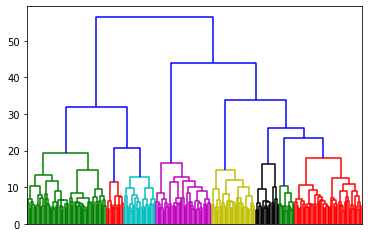

In [43]:
somhcl_all_df = comboCluster(mergeDfs([zdf_E, zdf_L, zdf_embryo]), gene_all, cth=20, gridheight=27, gridwidth=10)


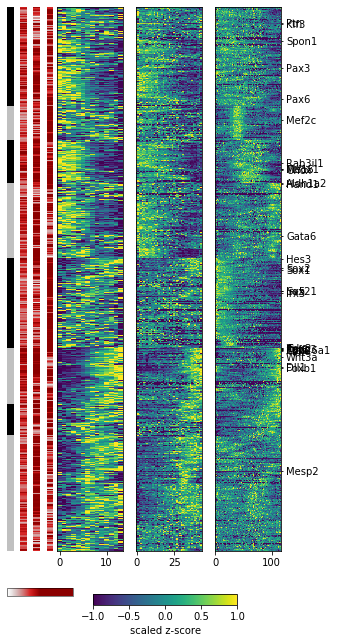

In [44]:
fig, ax = plt.subplots(ncols=3, nrows=1, figsize = (4,10))

hcl = somhcl_all_df
dfs = [zdf_E, zdf_L, zdf_embryo]
gcs = [gcE, gcL, gcEmbryo]
gene_order = hcl.sort_values(by=['hcl','som']).index

im = ['' for i in range(len(ax))]
for i, df in enumerate(dfs):
    im[i] = ax[i].imshow(scalezscore(df.loc[gene_order][::-1]), aspect = 'auto')
    ax[i].set_yticks([])
ax[-1].tick_params('y', length = 2, labelleft=False, labelright=True, left = False, right=True)
ax[-1].set_yticks([i for i, g in enumerate(gene_order[::-1]) if g.rsplit('_')[1] in g_annotate])
ax[-1].set_yticklabels([g.rsplit('_')[1] for g in gene_order[::-1] if g.rsplit('_')[1] in g_annotate])

cbaxes = fig.add_axes([0.25, 0.05,0.5, 0.015])
fig.colorbar(im[-1], label = 'scaled z-score', orientation = 'horizontal', cax = cbaxes)

dx = 0.1*len(dfs[0].columns)
x0 = -8*dx
y0 = len(hcl)-0.5
for cl in set(hcl['hcl']):
    c = 'silver' if np.mod(cl,2)==0 else 'k'
    n = (hcl['hcl']==cl).sum()
    rect = Rectangle((x0,y0-n), dx, n, lw = 2, edgecolor = None, facecolor = c, clip_on=False)
    ax[0].add_patch(rect)
    y0 -= n

npoints = 100
xra = np.linspace(0,1,npoints)
gcolors = list(Color('darkred').range_to(Color('white'),npoints-1))
colors = {(xra[i],xra[i+1]): gcolors[i].hex_l for i in range(npoints-1)}
for i, gc in enumerate(gcs):
    x0 = (-6+2*i)*dx
    y0 = len(hcl)-0.5
    n = 0
    for i, g in enumerate(gene_order):
        c = colors[[i for i in colors if i[0]<=gc.loc[g]<i[1]][0]]
        rect = Rectangle((x0,y0-n), dx, 1, lw = 2, edgecolor = None, facecolor = c, clip_on=False)
        ax[0].add_patch(rect)
        y0 -= 1
    
dxx = 0
x0 = -8*dx
x1 = -3*dx
dL = 1.0*(x1-x0)/len(colors)
for i, c in enumerate(list(colors.keys())[::-1]):
    rect = Rectangle((x0+dxx,len(gene_order)+200), dxx+dL, 40, edgecolor = None, facecolor = colors[c], clip_on=False)
    ax[0].add_patch(rect)
    dxx += dL
rect = Rectangle((x0,len(gene_order)+200), 2*dxx-dL, 40, edgecolor = 'k', fill = False, clip_on=False, lw = 0.5)
ax[0].add_patch(rect)

plt.savefig('../results/comparison_LfngE14_mouse/heatmap_E14LfngEmbryo_allgenes.pdf', bbox_inches = 'tight')
hcl.sort_values(by=['hcl','som']).to_csv('../results/comparison_LfngE14_mouse/heatmap_E14LfngEmbryo_allgenes.tsv', sep = '\t')

plt.show()



In [46]:
fout = '../results/comparison_LfngE14_mouse/GOanalysis/population.tsv'
pd.DataFrame(pd.Series([idx.rsplit('_')[1] for idx in somhcl_all_df.index])).to_csv(fout, sep = '\t', index = None, header = None)


In [47]:
for cl in set(somhcl_all_df['hcl']):
    fout = '../results/comparison_LfngE14_mouse/GOanalysis/cl' + str(cl).zfill(2) + '.tsv'
    pd.DataFrame(pd.Series([idx.rsplit('_')[1] for idx in somhcl_all_df[somhcl_all_df['hcl']==cl].index])).to_csv(fout, sep = '\t', index = None, header = None)
    

# Compare the three simultaneously, taking only reproducible genes

In [48]:
cnt = Counter(list(genelist_E)+list(genelist_L)+list(genelist_embryo))
repr_genelist = [g for g in cnt if cnt[g] == 3]

In [49]:
len(repr_genelist), 5*np.sqrt(len(repr_genelist))

(222, 74.4983221287567)

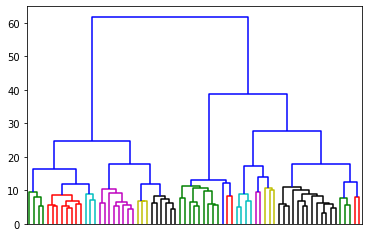

In [50]:
somhcl_reprall_df = comboCluster(mergeDfs([zdf_E, zdf_L, zdf_embryo]), repr_genelist, cth=11.5, gridheight=8, gridwidth=9)


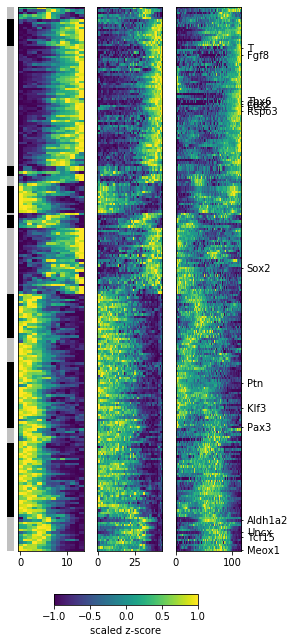

In [51]:
fig, ax = plt.subplots(ncols=3, nrows=1, figsize = (4,10))

hcl = somhcl_reprall_df
dfs = [zdf_E, zdf_L, zdf_embryo]
gcs = [gcE, gcL, gcEmbryo]
gene_order = hcl.sort_values(by=['hcl','som']).index

im = ['' for i in range(len(ax))]
for i, df in enumerate(dfs):
    im[i] = ax[i].imshow(scalezscore(df.loc[gene_order][::-1]), aspect = 'auto')
    ax[i].set_yticks([])
ax[-1].tick_params('y', length = 2, labelleft=False, labelright=True, left = False, right=True)
ax[-1].set_yticks([i for i, g in enumerate(gene_order[::-1]) if g.rsplit('_')[1] in g_annotate])
ax[-1].set_yticklabels([g.rsplit('_')[1] for g in gene_order[::-1] if g.rsplit('_')[1] in g_annotate])

cbaxes = fig.add_axes([0.25, 0.05,0.5, 0.015])
fig.colorbar(im[-1], label = 'scaled z-score', orientation = 'horizontal', cax = cbaxes)

dx = 0.1*len(dfs[0].columns)
x0 = -2*dx
y0 = len(hcl)-0.5
for cl in set(hcl['hcl']):
    c = 'silver' if np.mod(cl,2)==0 else 'k'
    n = (hcl['hcl']==cl).sum()
    rect = Rectangle((x0,y0-n), dx, n, lw = 2, edgecolor = None, facecolor = c, clip_on=False)
    ax[0].add_patch(rect)
    y0 -= n

plt.savefig('../results/comparison_LfngE14_mouse/heatmap_E14LfngEmbryo_ReprGenes.pdf', bbox_inches = 'tight')
hcl.sort_values(by=['hcl','som']).to_csv('../results/comparison_LfngE14_mouse/heatmap_E14LfngEmbryo_ReprGenes.tsv', sep = '\t')

plt.show()



In [52]:
new_order = {5:  14,
             2:  13,
             3:  12,
             1:  11,
             4:  10,
             9:  9,
             0:  8,
             14: 7,
             7:  6, 
             12: 5, 
             13: 4,
             6:  3, 
             8:  2, 
             10: 1, 
             11: 0}

In [53]:
somhcl_reprall_df['new-hcl'] = somhcl_reprall_df.apply(lambda x: new_order[x['hcl']], axis = 1)
somhcl_reprall_df.columns = ['som', 'hcl-old', 'hcl']
somhcl_reprall_df['neg_som'] = -somhcl_reprall_df['som']

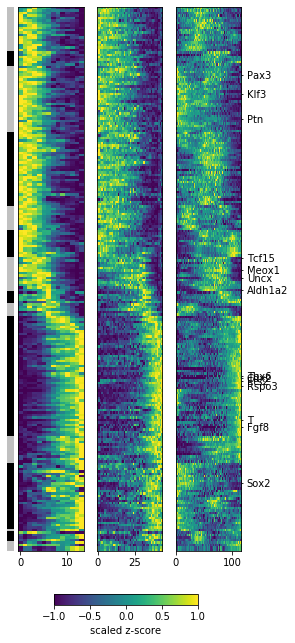

In [56]:
fig, ax = plt.subplots(ncols=3, nrows=1, figsize = (4,10))

hcl = somhcl_reprall_df
dfs = [zdf_E, zdf_L, zdf_embryo]
gcs = [gcE, gcL, gcEmbryo]
gene_order = hcl.sort_values(by=['hcl','neg_som']).index

im = ['' for i in range(len(ax))]
for i, df in enumerate(dfs):
    im[i] = ax[i].imshow(scalezscore(df.loc[gene_order][::-1]), aspect = 'auto')
    ax[i].set_yticks([])
ax[-1].tick_params('y', length = 2, labelleft=False, labelright=True, left = False, right=True)
ax[-1].set_yticks([i for i, g in enumerate(gene_order[::-1]) if g.rsplit('_')[1] in g_annotate])
ax[-1].set_yticklabels([g.rsplit('_')[1] for g in gene_order[::-1] if g.rsplit('_')[1] in g_annotate])

cbaxes = fig.add_axes([0.25, 0.05,0.5, 0.015])
fig.colorbar(im[-1], label = 'scaled z-score', orientation = 'horizontal', cax = cbaxes)

dx = 0.1*len(dfs[0].columns)
x0 = -2*dx
y0 = len(hcl)-0.5
for cl in set(hcl['hcl']):
    c = 'silver' if np.mod(cl,2)==0 else 'k'
    n = (hcl['hcl']==cl).sum()
    rect = Rectangle((x0,y0-n), dx, n, lw = 2, edgecolor = None, facecolor = c, clip_on=False)
    ax[0].add_patch(rect)
    y0 -= n

plt.savefig('../results/comparison_LfngE14_mouse/heatmap_E14LfngEmbryo_ReprGenes.pdf', bbox_inches = 'tight')
hcl.sort_values(by=['hcl','som']).to_csv('../results/comparison_LfngE14_mouse/heatmap_E14LfngEmbryo_ReprGenes.tsv', sep = '\t')

plt.show()

